In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.finance as mpf
from matplotlib.pylab import date2num
from HuobiServices import *
from DataUtils import *
import talib
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import os
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
lmap=lambda func,it: list(map(lambda x:func(x),it))
lfilter=lambda func,it: list(filter(lambda x:func(x),it))
z_score=lambda x:(x-np.mean(x,axis=0))/(np.std(x,axis=0)+1e-5)

In [78]:
class DuelingDQN_portfolio(object):
    def __init__(self, a_dim, s_dim,buffer_size,batch_size, update_target_interval=50, epsilon=0.9, gamma=0.9, learning_rate=1e-3):
        tf.reset_default_graph()
        self.a_dim, self.s_dim = a_dim, s_dim
        self.buffer_size=buffer_size
        self.batch_size=batch_size
        self.buffer = np.zeros((self.buffer_size, self.s_dim * 2+2), dtype=np.float32)
        self.buffer_length = 0
        self.update_target_interval=update_target_interval
        self.critic_loss = 0
        self.total_step = 0
        self.epsilon = epsilon
        self.learning_rate=learning_rate
        self.gamma=gamma
        self.s = tf.placeholder(tf.float32, [None, self.s_dim],name='s')
        self.s_next = tf.placeholder(tf.float32, [None, self.s_dim],name='s_next')
        self.q_next = tf.placeholder(tf.float32, [None, self.a_dim],name='q_next')
        
        
        
        with tf.variable_scope('q_eval', initializer=tf.contrib.layers.xavier_initializer(uniform=True), regularizer=tf.contrib.layers.l2_regularizer(0.01)) as scope:
            self.q_eval = self._build_net(self.s,scope)
            
        with tf.variable_scope('q_target', initializer=tf.contrib.layers.xavier_initializer(uniform=True), regularizer=tf.contrib.layers.l2_regularizer(0.01)) as scope:
            self.q_target = self._build_net(self.s_next,scope)
            
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_next, self.q_eval))
        with tf.variable_scope('train'):
            self.train_op = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)
            self.e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_eval')
            self.t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_target')
            self.update_q_target_op = [tf.assign(t, e) for t, e in zip(self.t_params, self.e_params)]
        self.init_op = tf.global_variables_initializer()
        self.session = tf.Session()
        self.saver = tf.train.Saver()
    
    def init_model(self):
        self.session.run(self.init_op)
    
    def _build_net(self, s, scope):
        with tf.variable_scope(scope):
            net = tf.layers.dense(s, 64, activation=tf.nn.tanh, name='l1')
            net = tf.layers.dense(net, 32, activation=tf.nn.tanh, name='l2')
            value = tf.layers.dense(net, 1, activation=None, name='a')
            advantage = tf.layers.dense(net,self.a_dim,activation=None,name='advantage')
            q=value+(advantage-tf.reduce_mean(advantage,axis=1,keep_dims=True))
            return q
        
    def trade(self, s, train=False):
        q = self.session.run(self.q_eval, {self.s: s})
        a = np.argmax(q)
        action=np.zeros(self.a_dim)
        if train:
            if np.random.uniform() < self.epsilon:
                action[a]=1.0
                return action
            else:
                action[np.random.randint(0,self.a_dim)]=1.0
                return action
        action[a]=1.0
        return action
    
    def update_target(self):
        self.session.run(self.update_q_target_op)

    def train(self):
        if self.buffer_length < self.buffer_size:
            return
        if self.total_step % self.update_target_interval == 0:
            self.session.run(self.update_q_target_op)
        s, a, r, s_next = self.get_transition_batch()
        q_eval, q_target = self.session.run([self.q_eval, self.q_target], {self.s: s, self.s_next: s_next})
        b_indices = np.arange(self.batch_size, dtype=np.int32)
        q_next = q_eval.copy()
        q_next[b_indices, a.astype(np.int)] = r + self.gamma * np.max(q_target, axis=1)
        _, self.critic_loss = self.session.run([self.train_op, self.loss], {self.s: s, self.q_next: q_next})
        self.total_step+=1

    def save_transition(self, s, a, r, s_next):
        a=np.argmax(a)
        transition = np.hstack((s, [a], [r], s_next))
        self.buffer[self.buffer_length % self.buffer_size, :] = transition
        self.buffer_length += 1
    
    def get_transition_batch(self):
        indices = np.random.choice(self.buffer_size, size=self.batch_size)
        batch = self.buffer[indices, :]
        s = batch[:, :self.s_dim]
        a = batch[:, self.s_dim: self.s_dim + 1]
        r = batch[:, -self.s_dim - 1: -self.s_dim]
        s_next = batch[:, -self.s_dim:]
        return s, a, r, s_next
    
    def restore_buffer(self):
        self.buffer = np.zeros((self.buffer_size, self.s_dim + 1 + 1 + self.s_dim))
        self.buffer_length=0
        
    def load_model(self, model_path='./DRLModel'):
        self.saver.restore(self.session, model_path + '/model')

    def save_model(self, model_path='./DRLModel'):
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        model_file = model_path + '/model'
        self.saver.save(self.session, model_file)

In [12]:
# assets=['kanbtc','mdsbtc','socbtc','xrpbtc','dbcbtc','eosbtc','wiccbtc','letbtc']
# assets=['kan','eos','mana']
# assets=['kan','wicc','edu','eos','let']
assets=assets=['bat']

In [13]:
asset_data=lfilter(lambda x:x[1] is not None,lmap(lambda x:(x,kline(x,interval='30min',count=2000)),assets))
asset_data=lmap(lambda x:(x[0],generate_tech_data(x[1],close_name='close',high_name='high',low_name='low',open_name='open')),asset_data)
asset_data=dict(asset_data)
asset_data=pd.Panel(asset_data)

In [79]:
model=DuelingDQN_portfolio(a_dim=asset_data.shape[0]+1,s_dim=asset_data.shape[2]*asset_data.shape[0],update_target_interval=100,  buffer_size=200, batch_size=128 ,learning_rate=1e-3)
model.init_model()
model.restore_buffer()

In [80]:
normalize_length=10
train_length=1500
c=1e-4
epoch=30
train_r=[]
train_mean_r=[]
test_r=[]
test_mean_r=[]
for e in range(epoch):
    train_reward=[]
    test_reward=[]
    test_actions=[]
    previous_action=np.zeros(asset_data.shape[0]+1)
    for t in range(normalize_length,train_length):
        state=asset_data[:,t-normalize_length:t,:].values
        next_state=asset_data[:,t-normalize_length+1:t+1,:].values
        state=state.reshape((state.shape[1],state.shape[0]*state.shape[2]))
        next_state=next_state.reshape((next_state.shape[1],next_state.shape[0]*next_state.shape[2]))
        state=z_score(state)[None,-1]
        next_state=z_score(next_state)[None,-1]
        action=model.trade(state,train=True)
        r=np.sum(asset_data[:,:,'diff'].iloc[t].values*action[:-1]-c*np.sum(np.abs(previous_action-action)))
        model.save_transition(s=state[0],a=action,r=r*10,s_next=next_state[0])
        model.train()
        previous_action=action
        train_reward.append(r)
    print(e,'train_reward',np.sum(train_reward),np.mean(train_reward))
    train_r.append(np.sum(train_reward))
    train_mean_r.append(np.mean(train_reward))
    previous_action=np.zeros(asset_data.shape[0]+1)
    for t in range(train_length,asset_data.shape[1]):
        state=asset_data[:,t-normalize_length:t,:].values
        state=state.reshape((state.shape[1],state.shape[0]*state.shape[2]))
        state=z_score(state)[None,-1]
        action=model.trade(state,train=False)
        r=np.sum(asset_data[:,:,'diff'].iloc[t].values*action[:-1]-c*np.sum(np.abs(previous_action-action)))
        test_reward.append(r)
        test_actions.append(action)
        previous_action=action
    print(e,'test_reward',np.sum(test_reward),np.mean(test_reward))
    test_r.append(np.sum(test_reward))
    test_mean_r.append(np.mean(test_reward))
    if np.sum(np.sum(test_reward))>0.45: break

0 train_reward -0.3985249895339599 -0.00026746643592883215
0 test_reward 0.05783659264382443 0.0001323491822513145
1 train_reward -0.26456463062895924 -0.0001775601547845364
1 test_reward 0.2069945436630398 0.00047367172462938167
2 train_reward 0.13427547501998494 9.011776846978854e-05
2 test_reward 0.10385172518475445 0.0002376469683861658
3 train_reward 0.017360615362133874 1.1651419706130116e-05
3 test_reward 0.07274162852738518 0.00016645681585214
4 train_reward -0.04658970148637883 -3.126825603112673e-05
4 test_reward 0.005463232949096709 1.2501677229054255e-05
5 train_reward -0.19864209216958834 -0.00013331684038227405
5 test_reward -0.022878724380023724 -5.235406036618701e-05
6 train_reward -0.12592620001407334 -8.451422819736466e-05
6 test_reward 0.053018521332298424 0.00012132384744233049
7 train_reward -0.22906053897591766 -0.00015373190535296487
7 test_reward 0.059424333429080434 0.0001359824563594518
8 train_reward -0.09196208629165772 -6.171952100111257e-05
8 test_reward 0

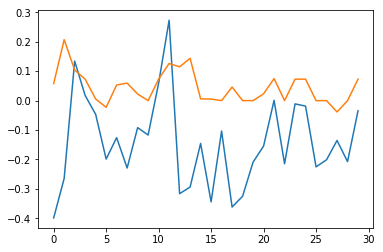

In [81]:
plt.plot(train_r)
plt.plot(test_r)

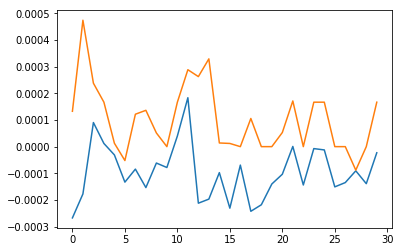

In [82]:
plt.plot(train_mean_r)
plt.plot(test_mean_r)

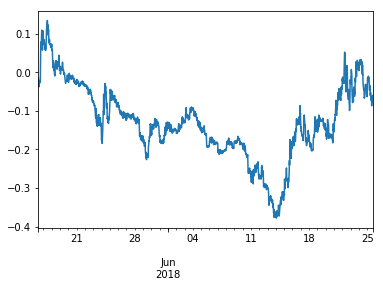

In [83]:
asset_data[:,:,'diff'].sum(axis=1).cumsum().plot()

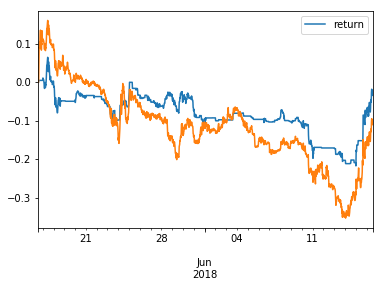

In [84]:
pd.DataFrame(train_reward,index=asset_data[:,normalize_length:train_length,'diff'].index,columns=['return']).cumsum().plot()
asset_data[:,normalize_length:train_length,'diff'].sum(axis=1).cumsum().plot()

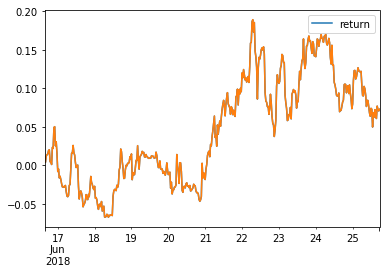

In [85]:
pd.DataFrame(test_reward,index=asset_data[:,train_length:,'diff'].index,columns=['return']).cumsum().plot()
asset_data[:,train_length:,'diff'].sum(axis=1).cumsum().plot()

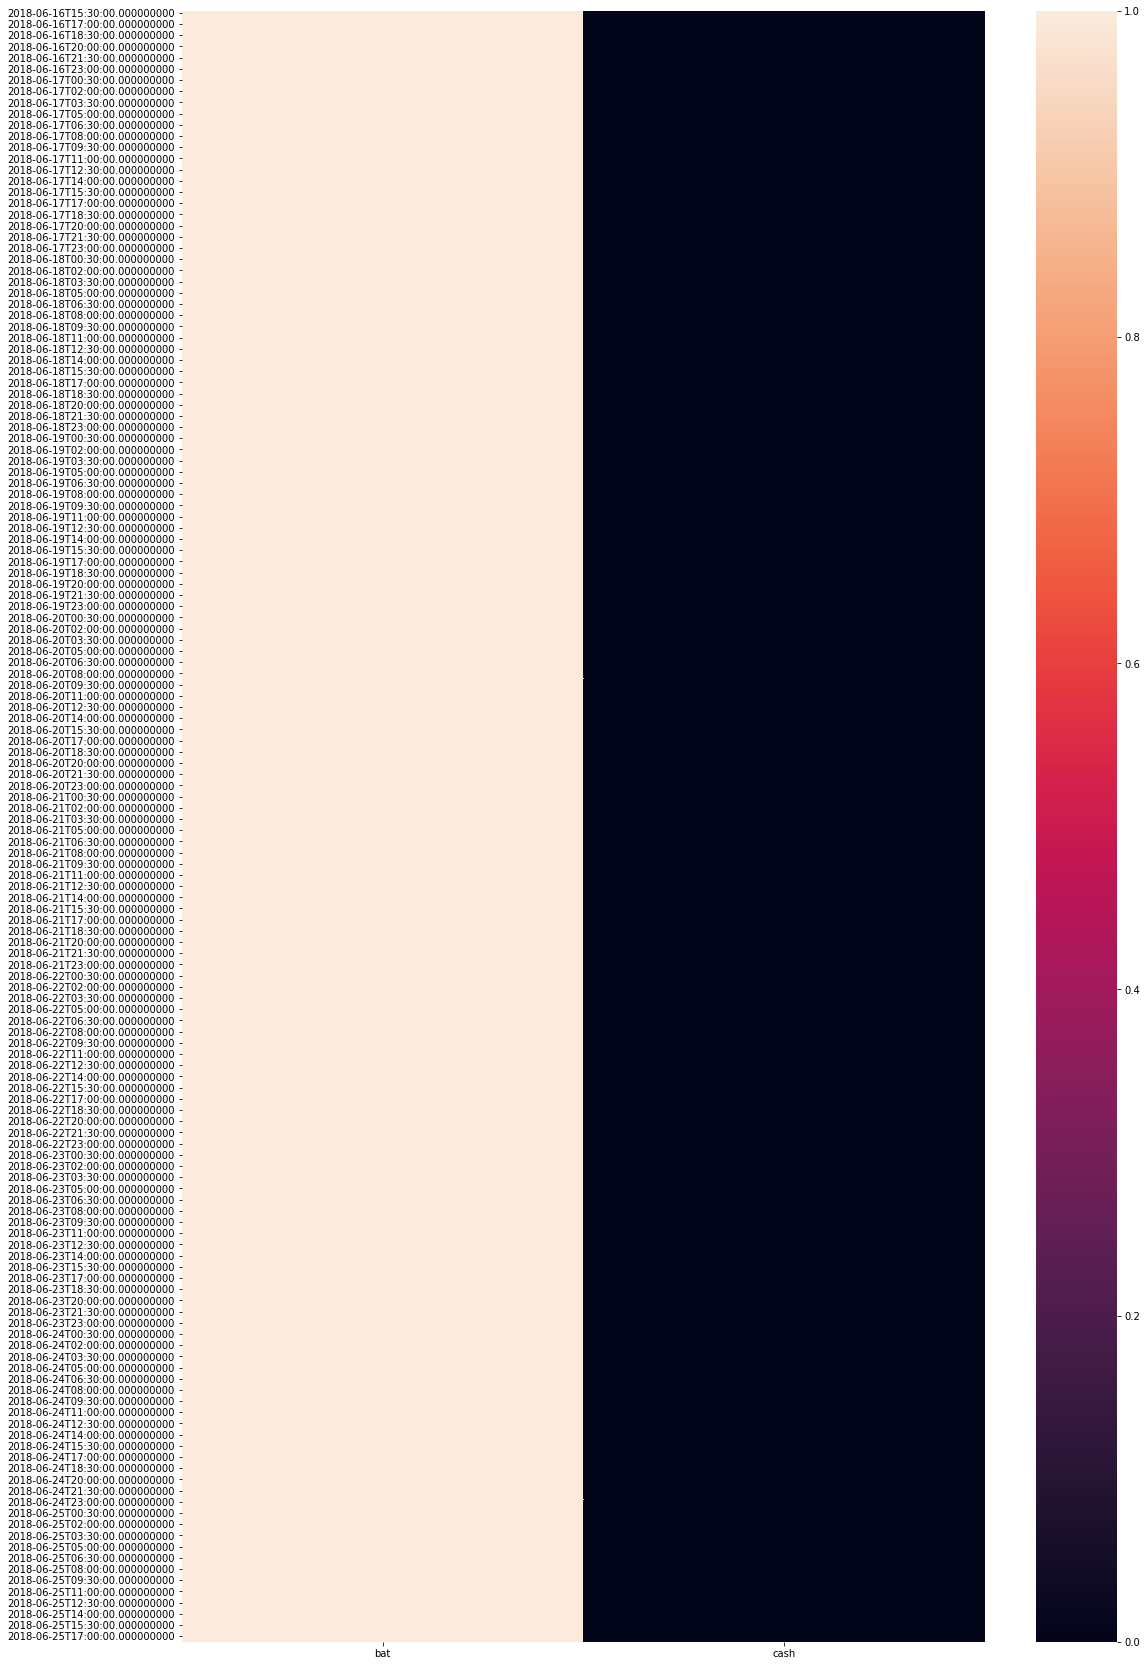

In [86]:
test_action_df=pd.DataFrame(test_actions,index=asset_data[:,train_length:,'diff'].index,columns=list(asset_data.items)+['cash'])
plt.figure(figsize=(18,30))
sns.heatmap(test_action_df)

In [87]:
np.abs(test_action_df.shift(1)-test_action_df).sum()

bat     0.0
cash    0.0
dtype: float64